<h1 style="text-align:center"> Fisher's Linear Discriminant </h1>
    <h3 style="text-align:center"> Fisher's Reduced-Rank Linear Discriminant Analysis</h3>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

 ## 1. Fit a linear model

### 1-1. Sample estimator

In [2]:
# k-Class mean

def mu_hat(x, N_k):
    return np.sum(x, axis=0)/N_k

In [3]:
# The covariance matrix

def sig(x, mu_hat):
    r,c = x.shape
    S = (x[0,:]-mu_hat).T*(x[0,:]-mu_hat) # both x[0,:] and mu_hat are row vectors
    for i in range(1,r):
        S += (x[i,:]-mu_hat).T*(x[i,:]-mu_hat)
    return S

## 2. For 2 classes

### 2-1. Coefficients from the Rayleigh quotient

$$\begin{align}
J(a) &= \frac{\lVert a^T\mu_1 - a^T \mu_2 \rVert^2}{a^T \Sigma_1 a + a^T \Sigma_2 a} \\
&= \frac{a^T S_B a}{a^T S_W a}
\end{align}$$
- $S_B$ : The between-class covariance matrix  
- $S_W$ : The within-class covariance matrix

$$\max_a J(a) \; \Rightarrow \; a \propto S_W^{-1}(m_1 - m_2)$$

In [4]:
def coeff_2k(sigW, m1, m2):
    inv_sigW = np.linalg.inv(sigW)
    return inv_sigW * (m1 - m2).T

$$S_W = \Sigma_1 + \Sigma_2$$

In [5]:
def sigW_2k(xs, mu_hats):
    S1 = sig(xs[0], mu_hats[0]) 
    S2 = sig(xs[1], mu_hats[0])
    return S1 + S2

### 2-2. Example

- The number of data, $N = 100$
- The number of features, $p = 4$
- The number of classes, $K = 2$

#### 2-2-1. Input values

In [6]:
np.random.seed(15)

x1_p1 = np.matrix(np.random.normal(loc=0.8,scale=0.1,size=(40,1))) 
x1_p2 = np.matrix(np.random.normal(loc=1,scale=0.4,size=(40,1)))
x1_p3 = np.matrix(np.random.normal(loc=0.3,scale=0.2,size=(40,1)))
x1_p4 = np.matrix(np.random.normal(loc=0.2,scale=0.5,size=(40,1)))
x1 = np.column_stack([x1_p1, x1_p2, x1_p3, x1_p4])

x2_p1 = np.matrix(np.random.normal(2,0.3, size=(60,1)))
x2_p2 = np.matrix(np.random.normal(3,0.2, size=(60,1)))
x2_p3 = np.matrix(np.random.normal(0.2,0.5, size=(60,1)))
x2_p4 = np.matrix(np.random.normal(0.7,0.8, size=(60,1)))
x2 = np.column_stack([x2_p1, x2_p2, x2_p3, x2_p4])

#### 2-2-2. Calculate mean, variance, and coefficient

In [7]:
m1 = mu_hat(x1, 40) # (1X4) matrix
m2 = mu_hat(x2, 60)

In [8]:
m1.shape

(1, 4)

In [9]:
SigB_2k = sig(m1, m2) 
SigB_2k

matrix([[ 1.42380282,  2.33671335, -0.18885126,  0.56500604],
        [ 2.33671335,  3.83496171, -0.30993847,  0.92727529],
        [-0.18885126, -0.30993847,  0.02504897, -0.07494163],
        [ 0.56500604,  0.92727529, -0.07494163,  0.2242107 ]])

In [10]:
xs = [x1, x2]
mu_hats = [m1, m2]
SigW_2k = sigW_2k(xs, mu_hats)
SigW_2k

matrix([[ 91.0837921 , 140.7682961 , -13.61798512,  33.71943395],
        [140.7682961 , 239.64530859, -19.11239747,  54.58711545],
        [-13.61798512, -19.11239747,  17.22442519,  -1.07765731],
        [ 33.71943395,  54.58711545,  -1.07765731,  63.01412496]])

In [11]:
coeffs_2k = coeff_2k(SigW_2k, m1, m2)
coeffs_2k

matrix([[-0.00521439],
        [-0.00507993],
        [-0.0005916 ],
        [-0.0003336 ]])

#### 2-2-3. Choose the threshold

In the text book, we should choose an adequate threshold and then I use the Mahalanobis distance.

$$c_m = \frac{s_2m_1 + s_2m_2}{s_1 + s_2}$$

- $m$: The projected mean value
- $s$: The standard deviation

In [12]:
proj_m1 = m1 * coeffs_2k
proj_m2 = m2 * coeffs_2k
s1 = np.std(x1 * coeffs_2k)
s2 = np.std(x2 * coeffs_2k)

In [13]:
def threshold(s1, s2, proj_m1, proj_m2, coeff):
    return ((s2 * proj_m1 + s1 * proj_m2) / (s1 + s2))[0,0]

In [14]:
cm = threshold(s1, s2, proj_m1, proj_m2, coeffs_2k)
cm

-0.01913479984870239

In [15]:
proj_m2

matrix([[-0.02580872]])

#### 2-3-4. Test by the decision rule

In [16]:
if x1[10,:] * coeffs_2k > cm:
    print("x1 belongs to class 1")
else:
    print("x1 belongs to class 2")

x1 belongs to class 1


In [17]:
if x2[10,:] * coeffs_2k > cm:
    print("x1 belongs to class 1")
else:
    print("x2 belongs to class 2")

x2 belongs to class 2


In [18]:
new_x = np.matrix(np.random.normal(loc=1.5,scale=0.4,size=(1,4))) 
new_x

matrix([[2.17528963, 1.51631199, 2.14368803, 1.11004105]])

In [19]:
if new_x * coeffs_2k > cm:
    print("New data belongs to class 1")
else:
    print("New data belongs to class 2")

New data belongs to class 2


## 3. Plotting (2 features)

In [20]:
plot_x1 = x1[:, 0:2]
plot_x2 = x2[:, 0:2]
plot_x = np.vstack((plot_x1, plot_x2))

In [21]:
plot_m1= mu_hat(plot_x1, 40)
plot_m2 = mu_hat(plot_x2, 60)

In [22]:
plot_Sig_2k = sig(plot_m1, plot_m2)

In [23]:
plot_xs = [plot_x1, plot_x2]
plot_mu_hats = [plot_m1, plot_m2]
plot_SigW_2k = sigW_2k(plot_xs, plot_mu_hats)
plot_SigW_2k

matrix([[ 91.0837921 , 140.7682961 ],
        [140.7682961 , 239.64530859]])

In [24]:
plot_coeffs_2k = coeff_2k(plot_SigW_2k, plot_m1, plot_m2)
plot_coeffs_2k

matrix([[-0.00511165],
        [-0.00516909]])

In [25]:
plot_proj_m1 = plot_m1 * plot_coeffs_2k
plot_proj_m2 = plot_m2 * plot_coeffs_2k
plot_s1 = np.std(plot_x1 * plot_coeffs_2k)
plot_s2 = np.std(plot_x2 * plot_coeffs_2k)

In [26]:
plot_cm = threshold(plot_s1, plot_s2, plot_proj_m1, plot_proj_m2, plot_coeffs_2k)

### 3-1. Test

In [27]:
plot_new_x = np.array([1.6,2]) 

In [28]:
if plot_new_x * plot_coeffs_2k > plot_cm:
    print("New data belongs to class 1")
else:
    print("New data belongs to class 2")

New data belongs to class 1


### 3-2. Decision Boundary
$$y = -\frac{a_1}{a_2} x + \frac{c_m}{a_2}$$

In [29]:
line_x = np.array(plot_x[:,0])

line_coeff1 = np.array(plot_coeffs_2k[0])
line_coeff2 = np.array(plot_coeffs_2k[1])

line_y = - line_coeff1/line_coeff2 * line_x + plot_cm/line_coeff2

Text(0, 0.5, '$X_2$')

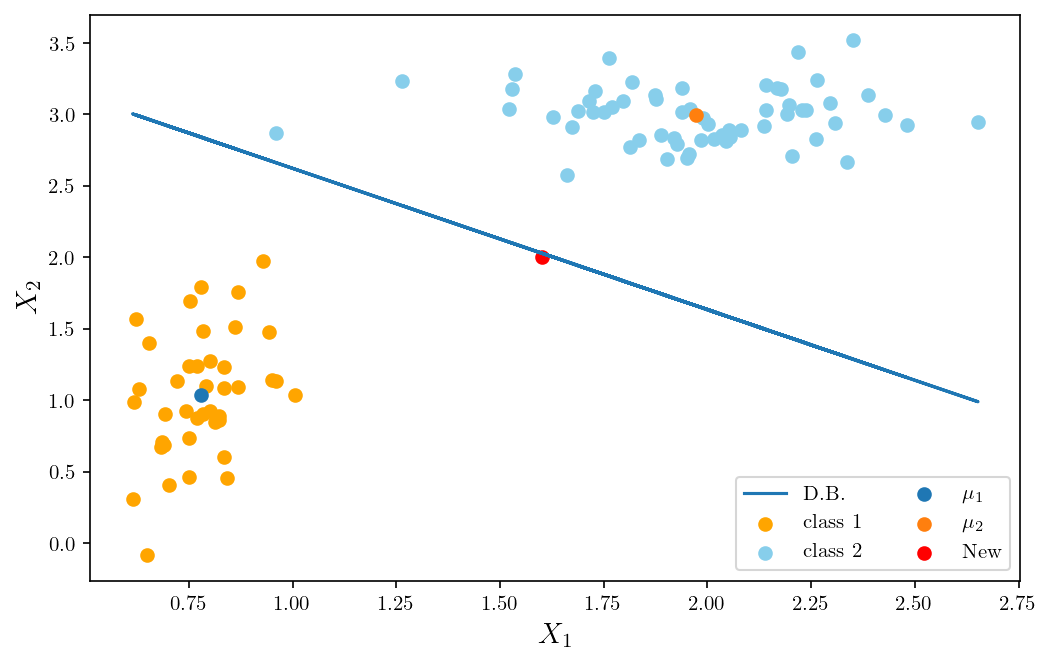

In [30]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(8,5), dpi=150)

plt.scatter(np.array(x1[:,0]), np.array(x1[:,1]), color="orange", label="class 1")
plt.scatter(np.array(x2[:,0]), np.array(x2[:,1]), color="skyblue", label="class 2")

plt.scatter(np.array(mu_hat(plot_x1[:,0], 40)), np.array(mu_hat(plot_x1[:,1], 40)), label=r"$\mu_1$")
plt.scatter(np.array(mu_hat(plot_x2[:,0], 60)), np.array(mu_hat(plot_x2[:,1], 60)), label=r"$\mu_2$")

plt.scatter(plot_new_x[0], plot_new_x[1],color="red", label="New")

plt.plot(line_x, line_y, label="D.B.")

plt.legend(loc="lower right", ncol=2)

plt.xlabel(r'$X_1$', fontsize=14)
plt.ylabel(r'$X_2$', fontsize=14)

Text(0, 0.5, 'Number')

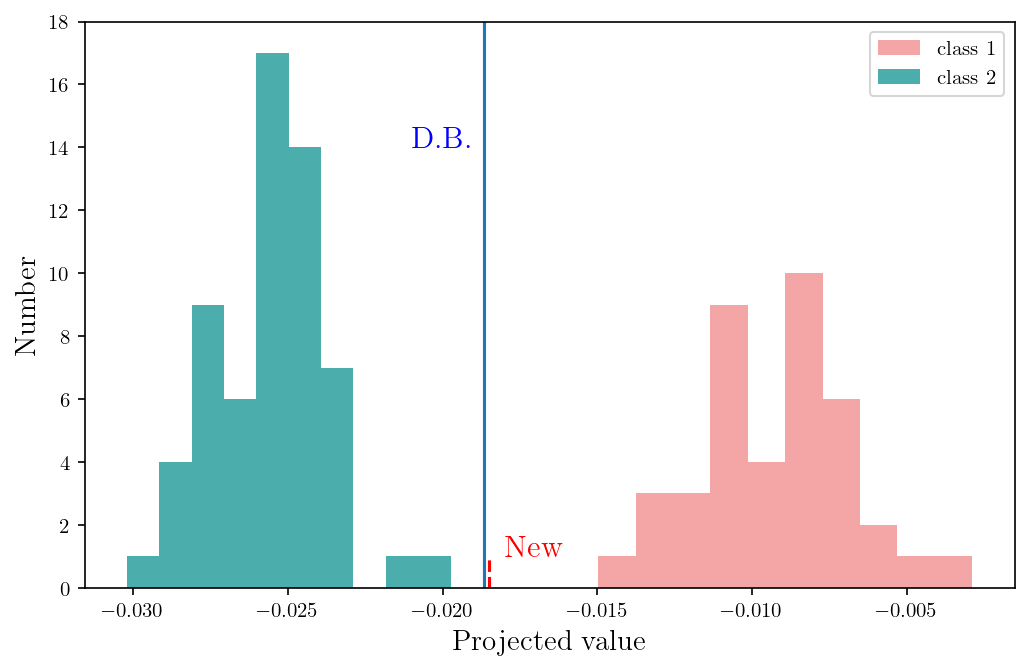

In [36]:
plt.figure(figsize=(8,5), dpi=150)

plt.hist(np.array(plot_x1 * plot_coeffs_2k), color="lightcoral" ,alpha=0.7, label="class 1")
plt.hist(np.array(plot_x2 * plot_coeffs_2k), color="darkcyan", alpha=0.7, label="class 2")

proj_new_x = (plot_new_x * plot_coeffs_2k)[0,0]
plt.plot(proj_new_x * np.ones(2), np.arange(2),ls="dashed" ,color = "red")
plt.plot(plot_cm * np.ones(19), np.arange(19))

plt.annotate('New', xy=(-0.018,1), c="red",fontsize=15)
plt.annotate('D.B.', xy=(-0.021,14), c="blue",fontsize=15)

plt.ylim([0,18])
plt.legend()

plt.xlabel(r'Projected value', fontsize=14)
plt.ylabel(r'Number', fontsize=14)


In [32]:
proj_new_x

-0.01851681417958085

In [33]:
np.asarray(plot_x1 * plot_coeffs_2k).ravel()

array([-0.01034592, -0.00736792, -0.01169098, -0.00762173, -0.00881538,
       -0.01128629, -0.00708009, -0.00818481, -0.00846493, -0.01259261,
       -0.01324622, -0.00989421, -0.01352866, -0.00663956, -0.00857406,
       -0.01222637, -0.00866465, -0.01078465, -0.01006733, -0.0106753 ,
       -0.00973344, -0.00569246, -0.0085208 , -0.00716   , -0.01064839,
       -0.00471942, -0.00695248, -0.0124345 , -0.0107575 , -0.0149687 ,
       -0.00825596, -0.00288569, -0.01056718, -0.00879003, -0.00864513,
       -0.00623843, -0.00886803, -0.01024133, -0.00955688, -0.01047823])